In [38]:
%load_ext autoreload
%autoreload 2
from scipy.stats import poisson
from utils import *
import math
from IPython.display import display, HTML
ins = BrainSpan()
mpl.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
#print bp_exon_col_meta.shape
#display(bp_exon_col_meta.head(2)) 
#print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
#print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
#display(bp_exon_row_meta.head(2))
#display(ExonExp.head(2))

In [40]:
def loaddict():
    res = {}
    fin = open("/Users/jiayao/Work/BrainDisorders/src/cds.dict", 'rb')
    for l in fin:
        llist = l.strip().split()
        gene, exon_s, cds_s, cds_e = llist[0], int(llist[1])-1, int(llist[2])-1, int(llist[3])
        if gene not in res:
            res[gene] = {}
        if exon_s not in res[gene]:
            res[gene][exon_s] = (cds_s, cds_e)
    return res
cds_dict = loaddict()
def addcds(row, cds_dict):
    s = row["start"]
    gene = row["gene_symbol"]
    if gene not in cds_dict:
        return row["exon length"]
    if s in cds_dict[gene]:
        cds_s, cds_e = cds_dict[gene][s]
        return cds_e - cds_s
    else:
        return row["exon length"]
    
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
bp_exon_row_meta["cds length"] = bp_exon_row_meta.apply(lambda row: addcds(row, cds_dict), axis=1)
bp_exon_row_meta.head(5)

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108,66
2,3,1086864,ENSG00000000003,TSPAN6,7105.0,99887481,99887565,84,84
3,4,1086864,ENSG00000000003,TSPAN6,7105.0,99888401,99888536,135,135
4,5,1086864,ENSG00000000003,TSPAN6,7105.0,99888927,99889026,99,99


In [41]:
def load_mutation_exp(VarFile, expdictfile, outname="tmp.targeted.exons.xlsx", row_meta=bp_exon_row_meta):
    row_meta = ins.AssignVar2Exon5(row_meta, VarFile, IntersectionWithPredicted=False)
    row_meta_with_gene = row_meta[row_meta["GeneHited"]=="T"]
    row_meta_with_gene.to_excel(outname, index=False)
    print "Num.of.Genes:", row_meta_with_gene.groupby('gene_symbol').count().shape

    expdict = ins.LoadGeneSetDataFromFil(expdictfile)
    Genes = list(set(row_meta_with_gene["gene_symbol"].values))
    gene_exon_set = GeneExonSet(expdict)
    for i, gene in enumerate(Genes):
        gene_df = row_meta_with_gene[row_meta_with_gene["gene_symbol"]==gene]
        TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
        UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
        TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
        UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
        gene_exon_set.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
    print len(gene_exon_set.genes), len(gene_exon_set.TargetedExon),len(gene_exon_set.UntargetedExon)
    return gene_exon_set

#[("proband LGD", 'red', prolgd), ("gnomAD LGD", 'blue', gnomADlgd),
# ("gnomAD male LGD", 'yellow', gnomADlgd_male),("gnomAD female LGD", 'green', gnomADlgd_female) ]

def plot_mutation_exp(title, datasets, ylims=((4,12.25))):
    fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
    plt.title(title)
    for i, (title, color, Dat) in enumerate(datasets):
        Tseq, Terr, Useq, Uerr, All, Allerr = Dat
        ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title, color=color)
        #ax.errorbar(range(2,14), Useq, yerr = Uerr, label="Exons without LGD mutations", color=color)
        ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)

    ax.grid(True)
    ax.axvline(x=7.5, color="grey", linestyle="--")
    plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.legend(loc='upper right', fontsize=8)
    plt.xlabel("Dev Stages")
    plt.ylabel("Expression")
    plt.ylim(ylims)
    plt.show()

In [42]:
VarFile = pd.read_csv("../data/benign.nonssych.tsv", delimiter="\t")
VarFile1 = VarFile[VarFile["AC"]==1]
expdictfile = "data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv"
ExAC_nonSYCH_LGD = load_mutation_exp(VarFile, expdictfile, outname="GenesExons.LGD_ExAC.nonSYCH_predicted.xlsx")
ExAC_nonSYCH_LGD_AC1 = load_mutation_exp(VarFile1, expdictfile, outname="GenesExons.LGD_ExAC.nonSYCH_predicted.1.xlsx")

309222Num.of.Genes: (82, 12)
82 205 1777
309222Num.of.Genes: (77, 12)
77 177 1731


In [43]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))
Genes = ExAC_nonSYCH_LGD.genes
#expdict = ins.LoadGeneSetDataFromFil("ProbandLGDz_all.Regionsgt20.GeneExonLog2Exp.csv")

ProbandLGD = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD.genes), len(ProbandLGD.TargetedExon),len(ProbandLGD.UntargetedExon)

ProbandLGD1 = GeneExonSet(expdict)
Genes = ExAC_nonSYCH_LGD_AC1.genes
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    ProbandLGD1.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(ProbandLGD1.genes), len(ProbandLGD1.TargetedExon),len(ProbandLGD1.UntargetedExon)

(94, 15)
82 92 1767
77 86 1703


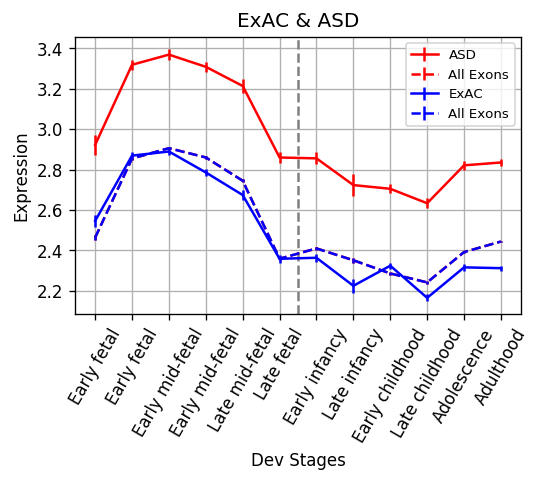

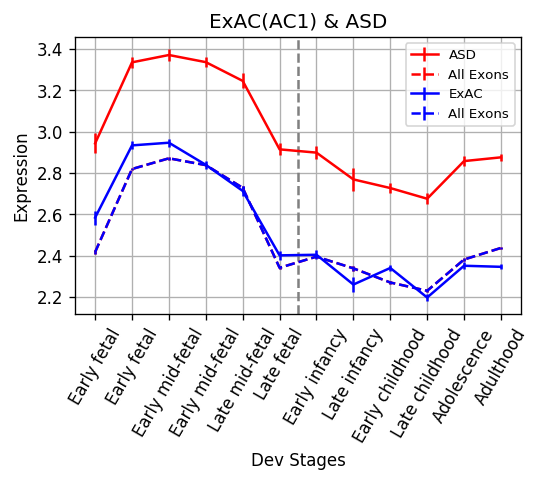

In [44]:
ssclgd = ProbandLGD.Reduce(logscale=True)
ssclgd1 = ProbandLGD1.Reduce(logscale=True)
exaclgd = ExAC_nonSYCH_LGD.Reduce(logscale=True)
exaclgd1 = ExAC_nonSYCH_LGD_AC1.Reduce(logscale=True)
datasets=[("ASD","red",ssclgd), ("ExAC","blue",exaclgd)]
plot_mutation_exp("ExAC & ASD", datasets, ylims=None)
datasets=[("ASD","red",ssclgd1), ("ExAC","blue",exaclgd1)]
plot_mutation_exp("ExAC(AC1) & ASD", datasets, ylims=None)

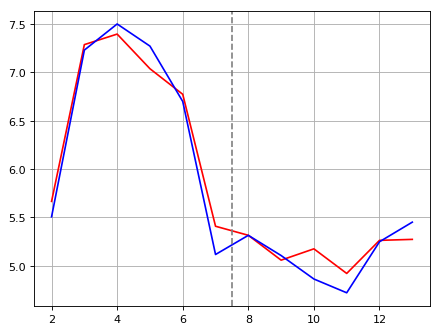

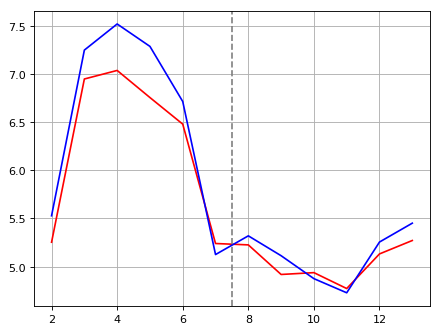

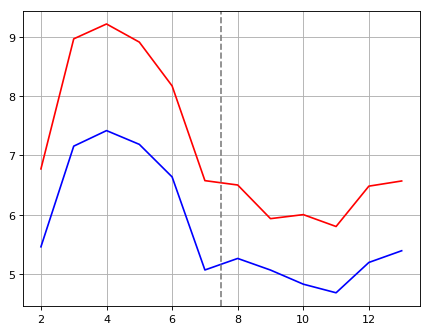

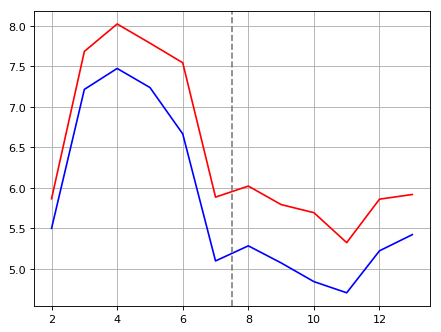

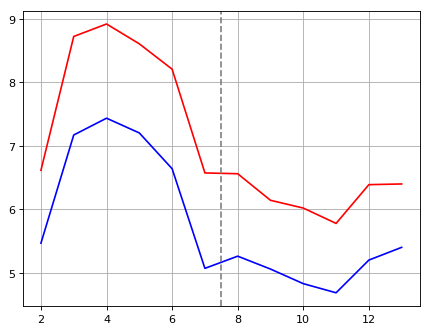

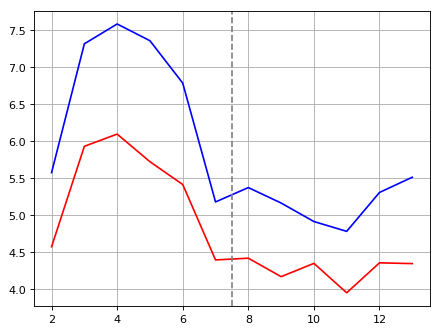

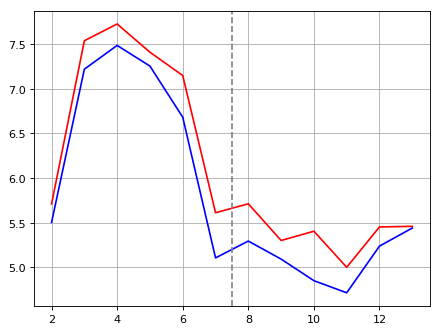

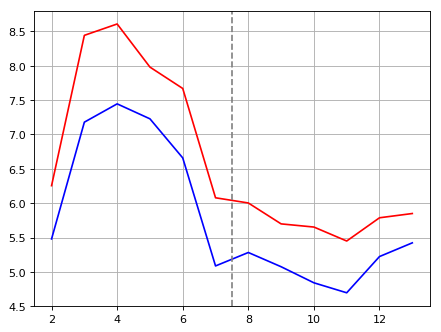

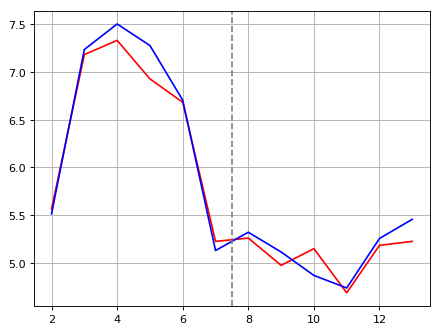

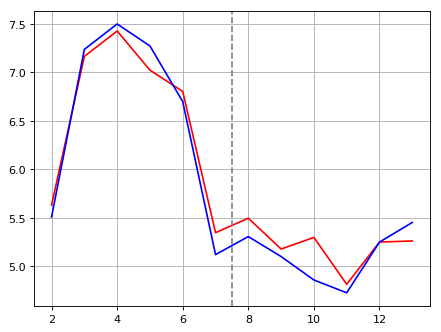

In [45]:
for i in range(10):
    bias, TE, UE = ProbandLGD.Permute(plot=True)
plt.show()

In [46]:
0.5 ** 20

9.5367431640625e-07

In [47]:
import re

_nsre = re.compile('([0-9]+)')
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower()
            for text in re.split(_nsre, s)]   
print sorted(Stages, key=natural_sort_key)

['2A', '2B', '3A', '3B', '4', '5', '6', '7', '8', '9', '10', '11']


In [48]:
GeneExonExp1 = {}
GeneExonExp = {}
for gene in expdict.keys():
    tmp = []
    GeneExonExp[gene] = {}
    for exon in expdict[gene].keys():
        exps = []
        for stage in expdict[gene][exon].keys():
            exps.extend(expdict[gene][exon][stage])
        exp = np.mean(exps)
        tmp.append((exon, exp))
        GeneExonExp[gene][exon] = exp
    GeneExonExp1[gene] = tmp

In [49]:
#AVG
exps = []
for k, v in GeneExonExp1.items():
    for exon, exp in v:
        exps.append(exp)
np.mean(exps)

2.562290861158163

In [50]:
GeneExonExp_sort = {}
for k, v in GeneExonExp1.items():
    v.sort(key = lambda x: x[1], reverse=True)
    GeneExonExp_sort[k] = v

In [51]:
for i in range(2,11):
    exps = []
    for k, v in GeneExonExp_sort.items():
        tmp = v[len(v)/i][1]
        exps.append(tmp)
    print i, np.mean(exps)

2 2.68337856206
3 3.1089078356
4 3.29391599308
5 3.38656244407
6 3.46310700658
7 3.53052184271
8 3.58512109384
9 3.62114102239
10 3.64996367096


In [52]:
for i in range(2,11):
    exps = []
    for k, v in GeneExonExp_sort.items():
        tmp = v[-len(v)/i][1]
        exps.append(tmp)
    print i, 2 ** np.mean(exps)

2 6.42358443216
3 4.2550653707
4 3.20742344853
5 2.78278432355
6 2.47733953565
7 2.26530883685
8 2.07991033396
9 2.01716226483
10 1.89771468298


In [53]:
GeneExonExp_2 = {}
GeneExonExp_norm = {}
for k, v in GeneExonExp_sort.items():
    #if len(v) < 10 :
    #    continue
    GeneExonExp_norm[k] = {}
    v = [(v1, v2/v[0][1]) for (v1, v2) in v]
    GeneExonExp_2[k] = v
    for exon, exp in v:
        GeneExonExp_norm[k][exon] = exp

/Users/jiayao/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


1.0 5.01942695183e-05 0.607968610666


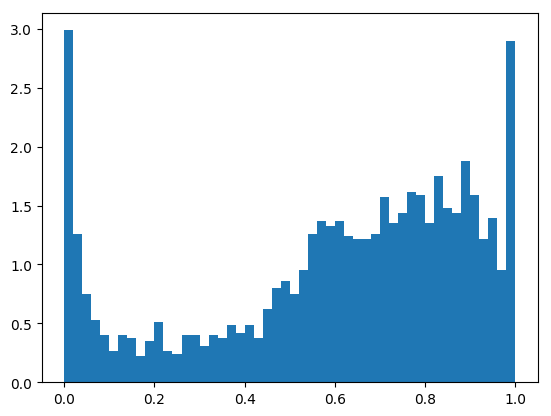

In [54]:
quantile = []
for k, v in GeneExonExp_2.items():
    quantile.extend([y for (x,y)in v])
#print qutiles
quantile = np.array(quantile)
quantile = quantile[~np.isnan(quantile)]
print max(quantile), min(quantile), np.mean(quantile)
plt.hist(quantile, bins=50, normed=1)
plt.show()

In [206]:
# ProbandLGD1 ExAC_nonSYCH_LGD_AC1
exp_ssc, exp_exac, exp_all = [], [], []
for gene in ProbandLGD1.genes:
    if gene not in GeneExonExp.keys():
        continue
    for exonID in ProbandLGD1.Genes[gene].TargetedExons:
        exp_ssc.append(GeneExonExp[gene][exonID])
    for exonID in ExAC_nonSYCH_LGD_AC1.Genes[gene].TargetedExons:
        exp_exac.append(GeneExonExp[gene][exonID])
    for exonID in ProbandLGD1.Genes[gene].TargetedExons + ProbandLGD1.Genes[gene].UntargetedExons:
        exp_all.append(GeneExonExp[gene][exonID])
exp_mix = exp_ssc + exp_exac*1

86 2.99016608588 166 2.51530582127 1789 2.50650055427 252 2.6773613084
MannwhitneyuResult(statistic=8758.5, pvalue=0.0031483692926807028)
MannwhitneyuResult(statistic=147065.5, pvalue=0.83816583453272031)
MannwhitneyuResult(statistic=22536.5, pvalue=0.18010121059246176)


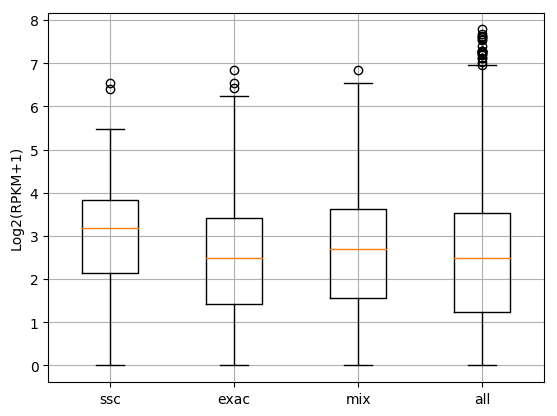

In [223]:
print len(exp_ssc),np.mean(exp_ssc),len(exp_exac),np.mean(exp_exac), len(exp_all), np.mean(exp_all), len(exp_mix), np.mean(exp_mix)
print scipy.stats.mannwhitneyu(exp_ssc, exp_exac, alternative="two-sided")
print scipy.stats.mannwhitneyu(exp_all, exp_exac, alternative="two-sided")
print scipy.stats.mannwhitneyu(exp_mix, exp_exac, alternative="two-sided")
plt.boxplot([exp_ssc, exp_exac, exp_mix, exp_all], labels = ["ssc", "exac", "mix", "all"])
plt.ylabel("Log2(RPKM+1)")
plt.grid(True)
plt.show()

In [57]:
# ProbandLGD1 ExAC_nonSYCH_LGD_AC1
exp_ssc, exp_exac, exp_all = [], [], []
for gene in ProbandLGD1.genes:
    if gene not in GeneExonExp_norm.keys():
        continue
    for exonID in ProbandLGD1.Genes[gene].TargetedExons:
        exp_ssc.append(GeneExonExp_norm[gene][exonID])
    for exonID in ExAC_nonSYCH_LGD_AC1.Genes[gene].TargetedExons:
        exp_exac.append(GeneExonExp_norm[gene][exonID])
    for exonID in ProbandLGD1.Genes[gene].TargetedExons + ProbandLGD1.Genes[gene].UntargetedExons:
        exp_all.append(GeneExonExp_norm[gene][exonID])
exp_ssc = np.array(exp_ssc)
exp_exac = np.array(exp_exac)
exp_all = np.array(exp_all)
exp_ssc = exp_ssc[~np.isnan(exp_ssc)]
exp_exac = exp_exac[~np.isnan(exp_exac)]
exp_all = exp_all[~np.isnan(exp_all)]

85 0.750700720012 165 0.69568927504 1779 0.597850963702
MannwhitneyuResult(statistic=8120.0, pvalue=0.040888766877066086)
MannwhitneyuResult(statistic=120754.0, pvalue=0.00016230906186220646)


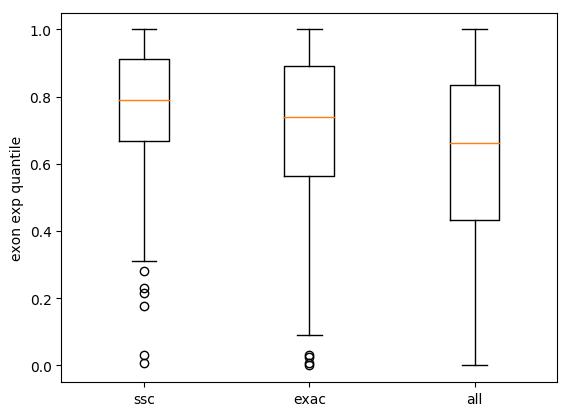

In [58]:
print len(exp_ssc),np.mean(exp_ssc),len(exp_exac),np.mean(exp_exac), len(exp_all),np.mean(exp_all)
print scipy.stats.mannwhitneyu(exp_ssc, exp_exac, alternative="two-sided")
print scipy.stats.mannwhitneyu(exp_all, exp_exac, alternative="two-sided")
plt.boxplot([exp_ssc, exp_exac, exp_all], labels = ["ssc", "exac", "all"])
plt.ylabel("exon exp quantile")
plt.show()

In [59]:
bp_exon_row_meta_with_gene = pd.read_excel("data/GenesExonsTargetedByLGD_wilger2014_predicted.xlsx", index=False)
bp_exon_row_meta_with_gene = bp_exon_row_meta_with_gene.replace(np.nan, '', regex=True)
print bp_exon_row_meta_with_gene.groupby('gene_symbol').count().shape
expdict = ins.LoadGeneSetDataFromFil("data/qn.ProbandLGD_PRE.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_with_gene["gene_symbol"].values))

SSCLGD_predicted = GeneExonSet(expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    SSCLGD_predicted.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(SSCLGD_predicted.genes), len(SSCLGD_predicted.TargetedExon),len(SSCLGD_predicted.UntargetedExon)

(94, 15)
94 118 2151


In [60]:
df = bp_exon_row_meta_with_gene
display(df.head(5))
print df[df["row_num"]==1250 ]["cds length"].values[0]

,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length,cds length,NVIQ70,VIQ70,Gender,Func,Vars,GeneHited,Last
0,1249,1086943,ENSG00000005108,THSD7A,221981,11410063,11415505,5442,82,,,,,,T,F
1,1250,1086943,ENSG00000005108,THSD7A,221981,11416196,11416284,88,88,,,,,,T,F
2,1251,1086943,ENSG00000005108,THSD7A,221981,11418696,11418907,211,211,,,,,,T,F
3,1252,1086943,ENSG00000005108,THSD7A,221981,11419256,11419382,126,83,,,,,,T,F
4,1253,1086943,ENSG00000005108,THSD7A,221981,11422147,11422243,96,96,,,,,,T,F


88


In [213]:
# GeneExonExp
Total_L, Effect_L = 0, 0
Total_exon, Effect_exon = 0, 0
effect_exps, non_effect_exps = [], []
Top_N_exps = []
last_N_exps = []
quantile = 0.75
quantile2 = 0.20
for gene in ProbandLGD1.genes:
    lower = 100
    total_length, effect_length = 0, 0
    exps = []
    for exon in ProbandLGD1.Genes[gene].TargetedExons:
        lower = GeneExonExp[gene][exon] if GeneExonExp[gene][exon] < lower else lower
    for exon in ProbandLGD1.Genes[gene].TargetedExons + ProbandLGD1.Genes[gene].UntargetedExons:
        exp = GeneExonExp[gene][exon]
        exps.append(exp)
        total_length += df[df["row_num"]==exon]["cds length"].values[0]
        if exp > lower:
            effect_length += df[df["row_num"]==exon]["cds length"].values[0]
            Effect_exon +=1
            effect_exps.append(exp)
        else:
            non_effect_exps.append(exp)
        Total_exon +=1
    exps.sort(reverse=True)
    N = int(quantile * len(exps))
    
    Top_N_exps.extend(exps[:N])
    last_N_exps.extend(exps[(N):])
    #print len(exps), len(exps[:N]), len(Top_60_exps)
    Total_L += total_length
    Effect_L += effect_length

In [214]:
print Total_L, Effect_L, float(Effect_L)/Total_L
print Total_exon, Effect_exon, float(Effect_exon)/Total_exon
print len(Top_N_exps), len(last_N_exps)

412142 134068 0.325295650528
1789 702 0.392397987703
1315 474


86 2.99016608588 166 2.51530582127 1789 2.50650055427 1315 3.00544352538


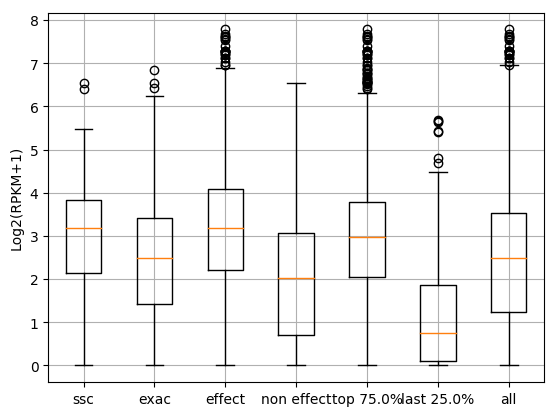

In [215]:
print len(exp_ssc),np.mean(exp_ssc),len(exp_exac),np.mean(exp_exac), len(exp_all), np.mean(exp_all), len(Top_N_exps), np.mean(Top_N_exps)
#print scipy.stats.mannwhitneyu(exp_ssc, exp_exac, alternative="two-sided")
#print scipy.stats.mannwhitneyu(exp_all, exp_exac, alternative="two-sided")
#print scipy.stats.mannwhitneyu(exp_mix, exp_exac, alternative="two-sided")
plt.boxplot([exp_ssc, exp_exac, effect_exps, non_effect_exps, Top_N_exps, last_N_exps, exp_all], 
            labels = ["ssc", "exac", "effect", "non effect", "top {}%".format(quantile*100), "last {}%".format((1-quantile)*100),"all"])
plt.ylabel("Log2(RPKM+1)")
plt.grid(True)
plt.show()

In [216]:
float(len(Top_N_exps)) / len(exp_all)

0.7350475125768586

In [217]:
import random
print random.random()

0.53692111441


In [218]:
res = []
import random
for gene in SSCLGD_predicted.genes:
    for exon in SSCLGD_predicted.Genes[gene].TargetedExons + SSCLGD_predicted.Genes[gene].UntargetedExons:
        #exp = GeneExonExp_norm[gene][exon] * GeneExonExp[gene][exon]
        if random.random() < GeneExonExp_norm[gene][exon]-0.1:
        #if random.random() > GeneExonExp_norm[gene][exon]-0.1:
            res.append(GeneExonExp[gene][exon])
res = np.array(res)
res = res[~np.isnan(res)]
#res = np.random.choice(res, size=116)

In [219]:
print len(res)

1142


86 2.99016608588 166 2.51530582127 1789 2.50650055427 1142 3.31477226369
MannwhitneyuResult(statistic=45591.0, pvalue=0.26779986214902729)


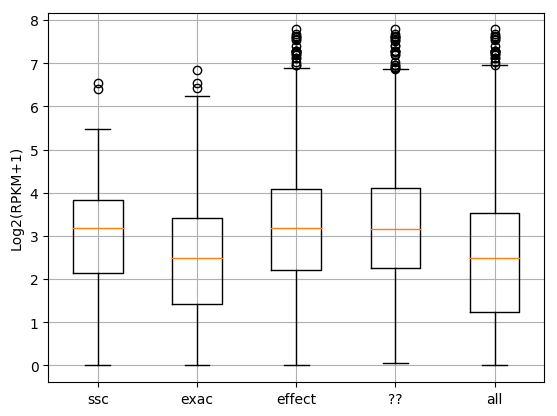

In [222]:
print len(exp_ssc),np.mean(exp_ssc),len(exp_exac),np.mean(exp_exac), len(exp_all), np.mean(exp_all), len(res), np.mean(res)
print scipy.stats.mannwhitneyu(exp_ssc, res, alternative="two-sided")
#print scipy.stats.mannwhitneyu(exp_all, exp_exac, alternative="two-sided")
#print scipy.stats.mannwhitneyu(exp_mix, exp_exac, alternative="two-sided")
plt.boxplot([exp_ssc, exp_exac, effect_exps, res, exp_all], 
            labels = ["ssc", "exac", "effect", "??","all"])
plt.ylabel("Log2(RPKM+1)")
plt.grid(True)
plt.show()

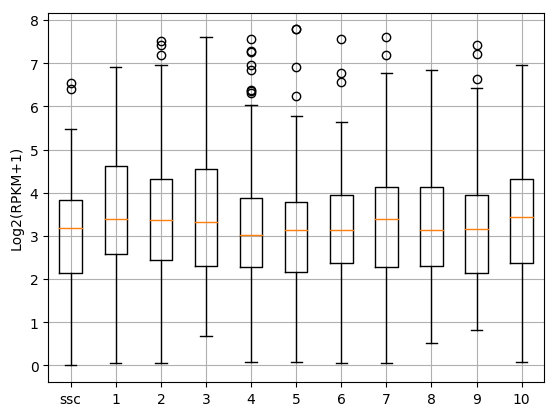

In [221]:
data = []
for i in range(10):
    tmp = np.random.choice(res, size=116)
    data.append(tmp)
plt.boxplot([exp_ssc] + data, 
            labels = ["ssc"] + [str(x+1) for x in range(10)])
plt.ylabel("Log2(RPKM+1)")
plt.grid(True)
plt.show()